# Sentence Length in Biblical Hebrew - Menzerath's Law

In [5]:
import sys, collections, os
import pandas as pd
import seaborn as sns
from scipy.stats.stats import pearsonr  
import numpy as np
sns.set()
import pprint as pp
import math
from matplotlib import pyplot as plt

from scipy import stats

In [6]:
from tf.fabric import Fabric
TF = Fabric(modules='hebrew/etcbc4c')

This is Text-Fabric 6.3.2
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

108 features found and 0 ignored


Activate relevant linguistic features

In [7]:
api = TF.load('''
    otype lex language
    typ code function rela det 
    vt vs txt sp mother uvf g_cons
''')

  0.00s loading features ...
   |     0.05s B otype                from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.17s B g_cons               from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.31s B lex                  from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.21s B language             from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.36s B typ                  from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.13s B code                 from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.14s B function             from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.42s B rela                 from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.30s B det                  from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.39s B vt                   from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.22s B vs            

In [8]:
api.loadLog()
api.makeAvailableIn(globals())

   |     0.05s B otype                from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.82s B oslots               from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.02s B book                 from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.02s B chapter              from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.02s B verse                from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.17s B g_cons               from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.30s B g_cons_utf8          from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.24s B g_lex                from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.30s B g_lex_utf8           from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.28s B g_word               from /Users/jAir/github/text-fabric-data/hebrew/etcbc4c
   |     0.40s B g_word_utf8          from /Users/jAir/githu

[('computed-data', ('C Computed', 'Call AllComputeds', 'Cs ComputedString')),
 ('edge-features', ('E Edge', 'Eall AllEdges', 'Es EdgeString')),
 ('loading', ('TF', 'ensureLoaded', 'ignored', 'loadLog')),
 ('locality', ('L Locality',)),
 ('messaging', ('cache', 'error', 'indent', 'info', 'reset')),
 ('navigating-nodes', ('N Nodes', 'sortKey', 'otypeRank', 'sortNodes')),
 ('node-features', ('F Feature', 'Fall AllFeatures', 'Fs FeatureString')),
 ('searching', ('S Search',)),
 ('text', ('T Text',))]

# Sentence - Clause - Phrase: data collection and Analysis

> The MAL stipulates:“The longer a language construct the shorter its components (constituents)”
>> In this section I gather data for the sentence level. I will analyze the correlation between sentence length (measured in number of clauses) and clause length (measured in number of phrases). Since it is not necessary to determine the length of each clause within a sentence, the mean length is calculated by counting the number of phrases within a sentence and dividing that by the number of clauses. Thus, for each sentence, we will know how many clauses it has and how many phrases each clause in that sentence has (on average).
>>>If the MAL holds for biblical Hebrew, we will see long sentences have short clauses.

In [9]:
# collect the data
sentence_list = []
sentence_dict = {}

number_clauses = []
number_phrases = []
clause_phrase_ratio = []

for sen in F.otype.s('sentence'):
    clauses = L.d(sen, 'clause')
    cl_counter = 0
    
    for cl in clauses:
        cl_counter += 1
        
    all_phrases = L.d(sen, 'phrase')
    phr_counter = 0
    
    for phr in all_phrases:  
        phr_counter += 1
        
    info_list = [str(cl)]
    
    where = T.sectionFromNode(cl)
    for elem in where:
        info_list.append(str(elem))
    words = L.d(cl, 'word')
    lang = F.language.v(words[0])
    info_list.append(lang)
    info_list.append(str(cl_counter))
    number_clauses.append(cl_counter)
    info_list.append(str(phr_counter))
    number_phrases.append(phr_counter)
    info_list.append(str(phr_counter / cl_counter))
    clause_phrase_ratio.append(phr_counter / cl_counter)
    
    sentence_list.append(cl)
    sentence_dict[cl] = info_list

In [10]:
# create csv
csvh = open('sentence_clause_phrase.csv', "w")
header = ['id', 'book', 'chapter', 'verse', 'language', 'sentence_length', 'number_phrases', 'clause_length']
csvh.write('{}\n'.format(','.join(header)))
for sen in sentence_list:
    line = sentence_dict[sen]
    csvh.write('{}\n'.format(','.join(line)))
    
csvh.close()

In [11]:
# load csv into pandas dataframe
sen_len = pd.read_csv('/Users/jAir/Desktop/ipynb/sentence_clause_phrase.csv')

In [12]:
# create new column to label books as narrative or poetry
narrative = {'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', 
             '1_Kings', '2_Kings', '1_Chronicles', '2_Chronicls', 'Ruth', 'Esther', 'Ezra', 'Nehemiah', 'Jonah', 'Daniel'}

conditions = [
    (sen_len['book'] == 'Genesis'),
    (sen_len['book'] == 'Exodus'),
    (sen_len['book'] == 'Leviticus'),
    (sen_len['book'] == 'Numbers'),
    (sen_len['book'] == 'Deuteronomy'),
    (sen_len['book'] == 'Joshua'),
    (sen_len['book'] == 'Judges'),
    (sen_len['book'] == '1_Samuel'),
    (sen_len['book'] == '2_Samuel'),
    (sen_len['book'] =='1_Kings'),
    (sen_len['book'] =='2_Kings'),
    (sen_len['book'] =='1_Chronicles'),
    (sen_len['book'] =='2_Chronicles'),
    (sen_len['book'] == 'Ruth'),
    (sen_len['book'] =='Esther'),
    (sen_len['book'] =='Ezra'),
    (sen_len['book'] =='Nehemiah'),
    (sen_len['book'] =='Jonah'),
    (sen_len['book'] =='Daniel')]
choices = ['Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative',
          'Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative',]
sen_len['genre'] = np.select(conditions, choices, default = 'Poetry')

In [13]:
# create new dataframe with sentences that are shorter than 16 clauses
sen_len_15 = sen_len[sen_len['sentence_length'] < 16]

In [14]:
# dataframe with sentences that are shorter than 8 clauses
sen_len_7 = sen_len[sen_len['sentence_length'] < 8]

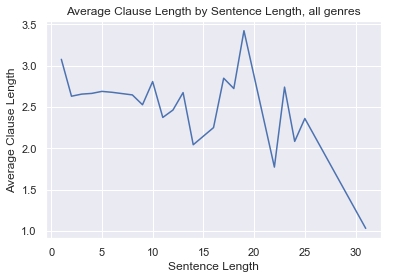

In [15]:
sen_len.clause_length.groupby(sen_len.sentence_length).mean().plot(kind='line')
plt.xlabel('Sentence Length')
plt.ylabel('Average Clause Length')
plt.title('Average Clause Length by Sentence Length, all genres')
plt.show()

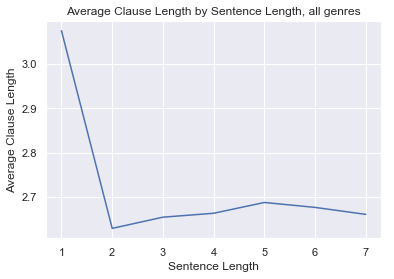

In [16]:
sen_len_7.clause_length.groupby(sen_len.sentence_length).mean().plot(kind='line')
plt.xlabel('Sentence Length')
plt.ylabel('Average Clause Length')
plt.title('Average Clause Length by Sentence Length, all genres')
plt.show()

In [17]:
# create dataframe with sentence lengths as rows and average clause length
# this dataframe is used to fit the data to the MAL linear model
ma = sen_len_7.clause_length.groupby(sen_len_7.sentence_length).mean()
ma_df = pd.DataFrame(ma)
ma_df.reset_index(level=0, inplace=True)
ma_df.head()

,sentence_length,clause_length
0,1,3.075193
1,2,2.629325
2,3,2.654567
3,4,2.663388
4,5,2.687727


SyL = a·WoL−b

ClL = a*SenL**-b

ClL = a*(1/SenL**b)



In [18]:
from numpy import exp, linspace, random
from lmfit import Model

[[Model]]
    Model(mla)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 7
    # variables        = 2
    chi-square         = 0.06834502
    reduced chi-square = 0.01366900
    Akaike info crit   = -28.4036768
    Bayesian info crit = -28.5118565
[[Variables]]
    a:  2.93199275 +/- 0.09759585 (3.33%) (init = 4.950447)
    b:  0.06194993 +/- 0.02491131 (40.21%) (init = 0.228)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.873



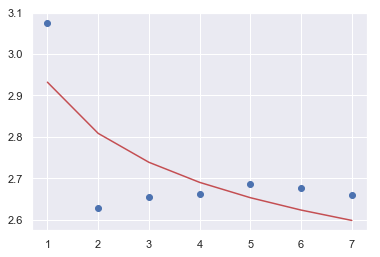

In [19]:
# fit all the data to the model
y = ma_df.clause_length
x = ma_df.sentence_length

def mla(x, a, b):
    return (a*(1/x**b))

mlamodel = Model(mla)
result = mlamodel.fit(y, x=x, a=4.950447, b=0.228)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.best_fit, 'r-')
plt.show()

In [20]:
a = result.params['a'].value
b = result.params['b'].value

In [21]:
# calculate R2
SenLp = []

for n in range(1,32):
    SenLp.append(a*(1/n**-b))

SenLp_df = pd.DataFrame(SenLp)
ma_df['senlp'] = SenLp_df

slope, intercept, r_value, p_value, std_err = stats.linregress(ma_df.clause_length, ma_df.senlp)
print("r-squared:", r_value**2)

r-squared: 0.507622024842303


Genesis r-squared: 0.7265055895639457
Genesis a: 0.1028695599891211


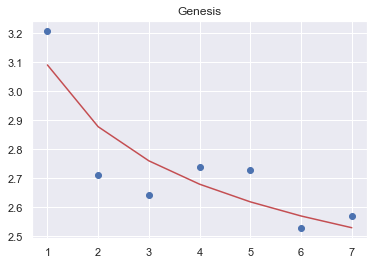

Exodus r-squared: 0.842502941088549
Exodus a: 0.12195965693169512


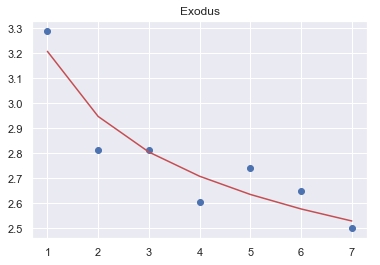

Leviticus r-squared: 0.6907640438316209
Leviticus a: 0.11072827701400195


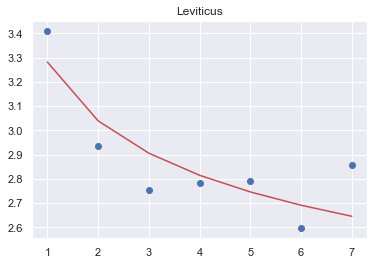

Numbers r-squared: 0.19832491569779237
Numbers a: 0.05030497978590202


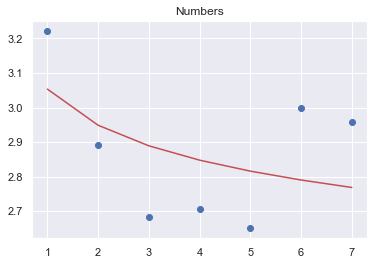

Deuteronomy r-squared: 0.7475859309289892
Deuteronomy a: 0.07771782506302082


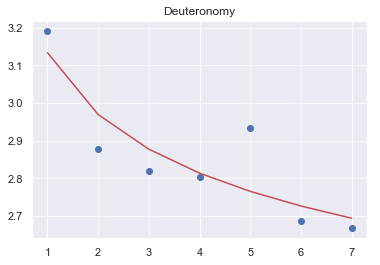

Joshua r-squared: 0.5714817175460494
Joshua a: 0.07635704613386639


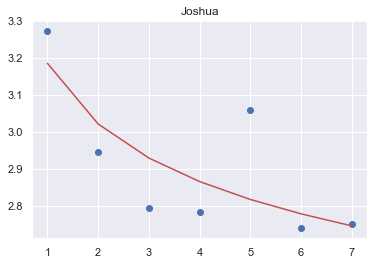

Judges r-squared: 0.8241958003767392
Judges a: 0.13510507406080371


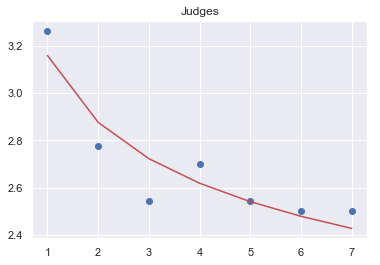

1_Samuel r-squared: 0.36683845683609306
1_Samuel a: 0.07022992643754966


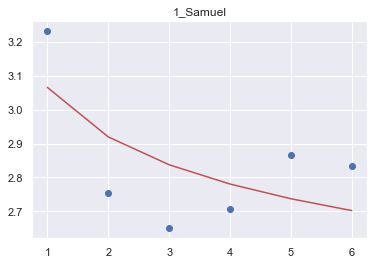

2_Samuel r-squared: 0.4699779047685839
2_Samuel a: 0.09690706296964215


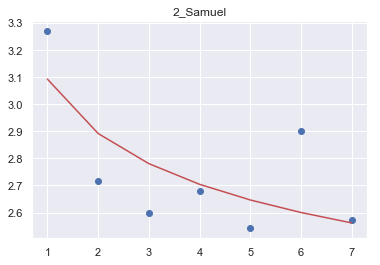

1_Kings r-squared: 0.2933279826627854
1_Kings a: 0.0520784187045599


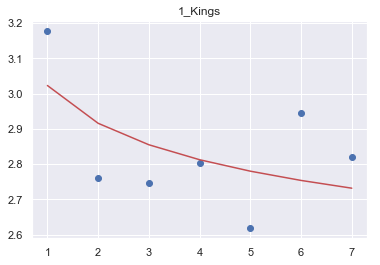

2_Kings r-squared: 0.025991944590683585
2_Kings a: 0.01740333136741924


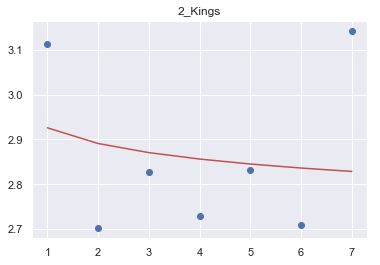

Isaiah r-squared: 0.40761856179724915
Isaiah a: 0.06724665292010028


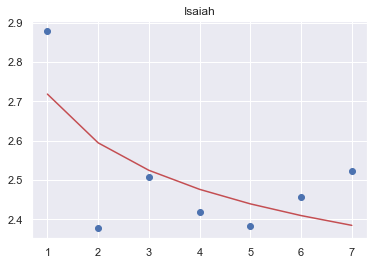

Jeremiah r-squared: 0.3102362720098461
Jeremiah a: 0.04674118039678563


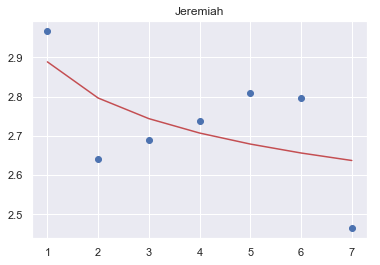

Ezekiel r-squared: 0.5270830904366565
Ezekiel a: 0.07840697881382576


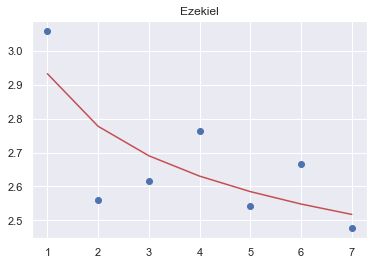

Hosea r-squared: 0.6812681258019335
Hosea a: 0.26896622936171266


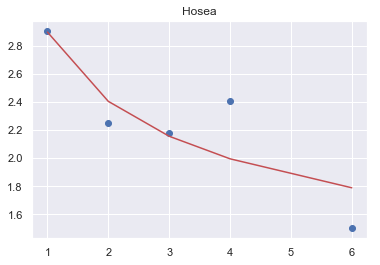

Joel r-squared: 0.09411215504386722
Joel a: -0.0944624909521042


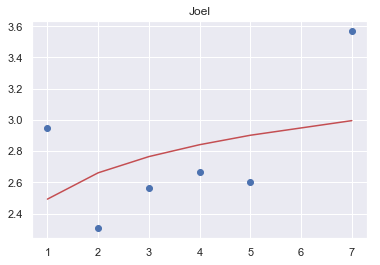

Amos r-squared: 0.3149342559329344
Amos a: 0.06354256794636814


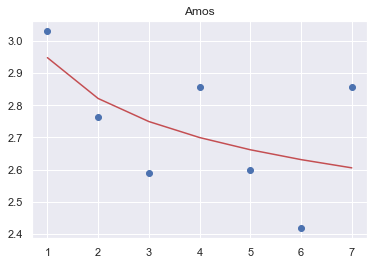

Obadiah r-squared: 0.0033360593122285726
Obadiah a: -0.027824557150732253


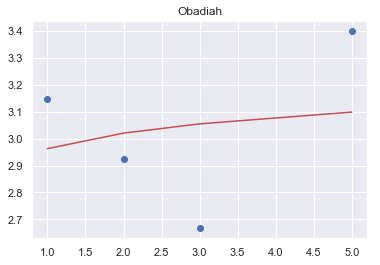

Jonah r-squared: 0.040702325842917594
Jonah a: 0.059007151132138856


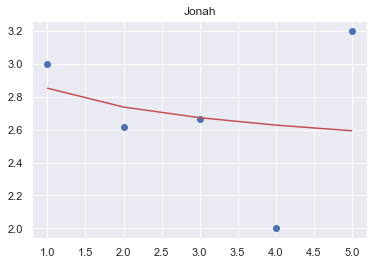

Micah r-squared: 0.28489044691602056
Micah a: 0.07631869347002694


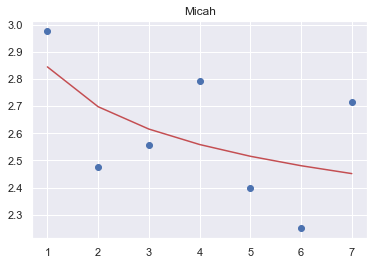

Nahum r-squared: 0.7432030942024235
Nahum a: 0.10385566847341089


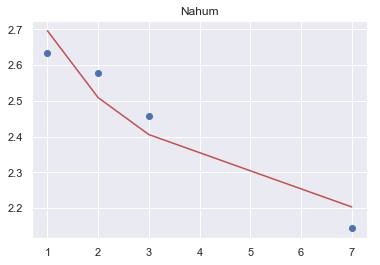

Habakkuk r-squared: 0.8781569832110133
Habakkuk a: 0.19548793458770222


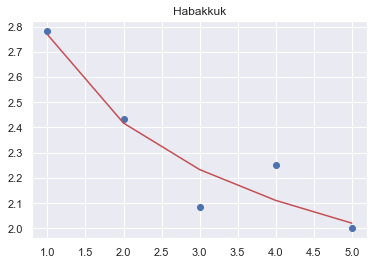

Zephaniah r-squared: 0.15888973597256983
Zephaniah a: -0.09386070582246614


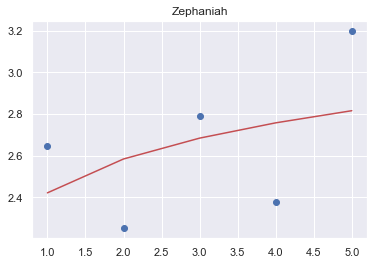

Haggai r-squared: 0.004522465027444448
Haggai a: -0.026615762101427982


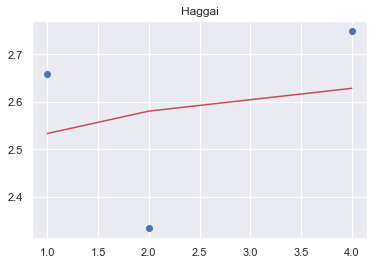

Zechariah r-squared: 0.3976291152808962
Zechariah a: 0.07991572957209546


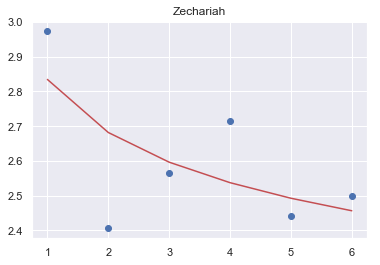

Malachi r-squared: 0.07938965238240181
Malachi a: 0.0318352392881684


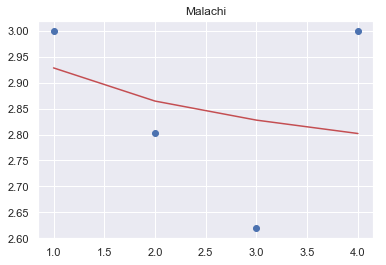

Psalms r-squared: 0.0931878770665089
Psalms a: -0.029060933620716073


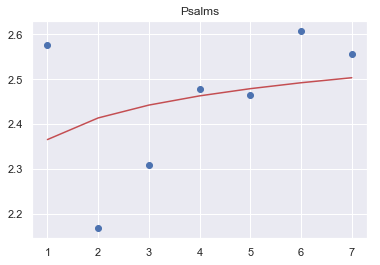

Job r-squared: 0.09094792667575026
Job a: 0.021212407289883804


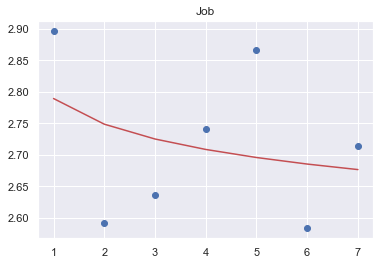

Proverbs r-squared: 0.791987521382423
Proverbs a: 0.22802306221973426


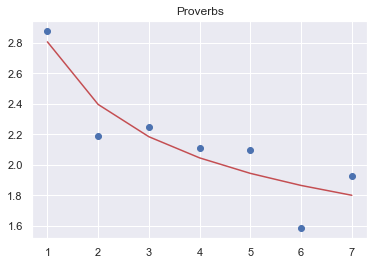

Ruth r-squared: 0.008586670167380031
Ruth a: -0.03043945642115659


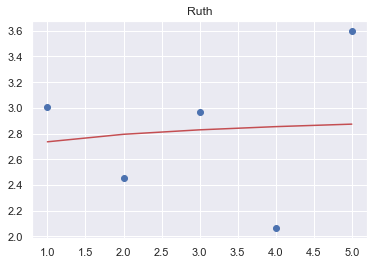

Song_of_songs r-squared: 0.005122890721391006
Song_of_songs a: -0.008160274483194868


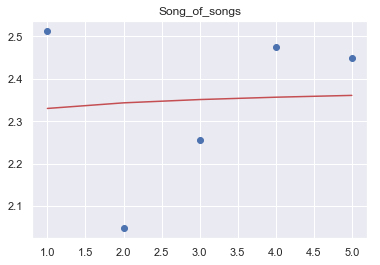

Ecclesiastes r-squared: 0.04637794650208964
Ecclesiastes a: 0.038875398976906755


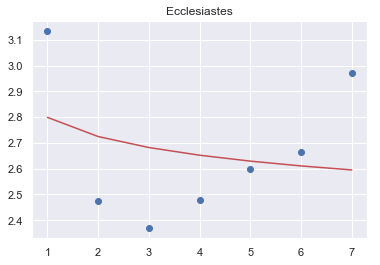

Lamentations r-squared: 0.005050758120102107
Lamentations a: 0.015501892937774691


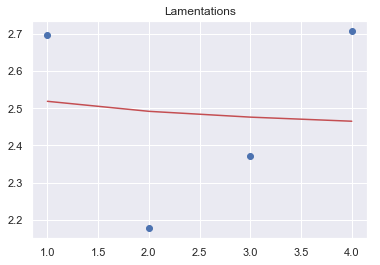

Esther r-squared: 0.6517167750453197
Esther a: 0.11305189569847417


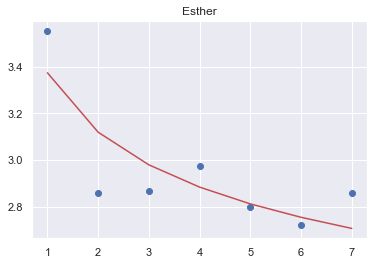

Daniel r-squared: 0.3225292386639977
Daniel a: 0.055659253043511214


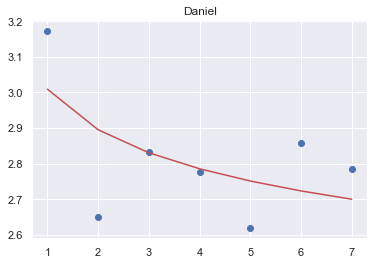

Ezra r-squared: 0.038112048610363644
Ezra a: 0.011975078312752937


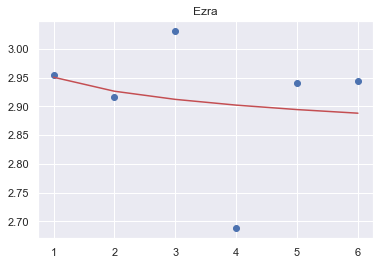

Nehemiah r-squared: 0.8220704578829263
Nehemiah a: 0.13593562730886405


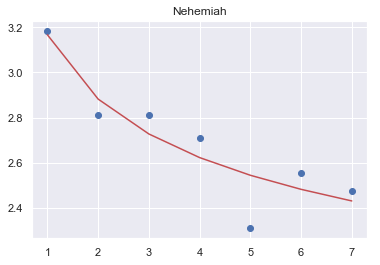

1_Chronicles r-squared: 0.6568957647410565
1_Chronicles a: 0.17265562790752667


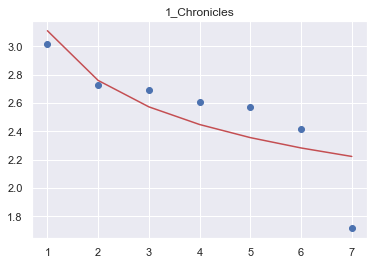

2_Chronicles r-squared: 0.45520756151823827
2_Chronicles a: 0.08108150751753139


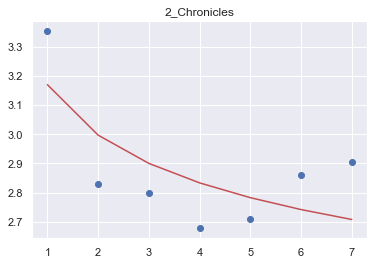

In [22]:
# fit the data for each book individualy to the model
r2 = {}
variable_a = {}
variable_b = {}

for book in sen_len.book.unique():
    ma = sen_len_7.loc[sen_len_7['book'] == book].clause_length.groupby(sen_len_7.sentence_length).mean()
    ma_df = pd.DataFrame(ma)
    ma_df.reset_index(level=0, inplace=True)
     
    y = ma_df.clause_length
    x = ma_df.sentence_length

    def mla(x, a, b):
        return (a*(1/x**b))

    mlamodel = Model(mla)
    result = mlamodel.fit(y, x=x, a=4.950447, b=0.228)

    SenLp = []
    for n in range(1,32):
        SenLp.append(a*(1/n**-b))

    SenLp_df = pd.DataFrame(SenLp)
    ma_df['senlp'] = SenLp_df
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ma_df.clause_length, ma_df.senlp)
    print(book, "r-squared:", r_value**2)
    r2[book] = r_value**2
    v_a = result.params['a'].value
    v_b = result.params['b'].value
    variable_a[book] = v_a
    variable_b[book] = v_b
    print(book, 'a:',v_b)

    
    plt.plot(x, y, 'bo')
    plt.plot(x, result.best_fit, 'r-')
    plt.title(book)
    plt.show()

In [23]:
# create dataframe with books as rows, along with R2 scores
sen_clause = pd.DataFrame(list(r2.items()), columns=['Book', 'R2'])
sen_clause['variable_a'] = sen_clause['Book'].map(variable_a)
sen_clause['variable_b'] = sen_clause['Book'].map(variable_b)

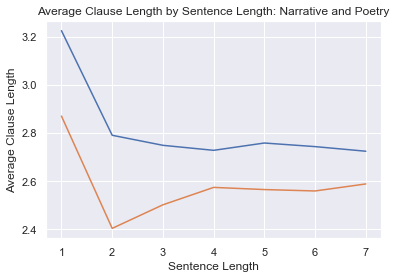

In [24]:
# compare narrative and poetry
sen_len_7.loc[sen_len_7.genre == 'Narrative'].clause_length.groupby(sen_len.sentence_length).mean().plot(kind='line')
sen_len_7.loc[sen_len_7.genre == 'Poetry'].clause_length.groupby(sen_len.sentence_length).mean().plot(kind='line')

plt.xlabel('Sentence Length')
plt.ylabel('Average Clause Length')
plt.title('Average Clause Length by Sentence Length: Narrative and Poetry')
plt.show()

# Clause - Phrase - Word: Data Collection and Analysis

> Here I repeat the above process on the Clause level. I analyze the correlation between clause length and phrase length

In [25]:
clause_list = []
clause_dict = {}

number_phrases = []
number_words2 = []
phrase_word_ratio = []

for cl in F.otype.s('clause'):
    phrases = L.d(cl, 'phrase')
    phr_counter2 = 0
    
    for phr in phrases:
        phr_counter2 += 1
        
    all_words = L.d(cl, 'word')
    word_counter = 0
    
    for w in all_words:  
        word_counter += 1
        
    info_list2 = [str(cl)]
    
    where = T.sectionFromNode(cl)
    for elem in where:
        info_list2.append(str(elem))
    words2 = L.d(cl, 'word')
    lang2 = F.language.v(words[0])
    info_list2.append(lang2)
    info_list2.append(str(phr_counter2))
    number_phrases.append(phr_counter2)
    info_list2.append(str(word_counter))
    number_words2.append(word_counter)
    info_list2.append(str(word_counter / phr_counter2))
    phrase_word_ratio.append(word_counter / phr_counter2)

    
    clause_list.append(cl)
    clause_dict[cl] = info_list2

In [26]:
csvh = open('clause_jarod2.csv', "w")
header = ['id', 'book', 'chapter', 'verse', 'language', 'number_phrases', 'number_words', 'ratio']
csvh.write('{}\n'.format(','.join(header)))
for cl in clause_list:
    line = clause_dict[cl]
    csvh.write('{}\n'.format(','.join(line)))
    
csvh.close()

In [27]:
cl_len = pd.read_csv('/Users/jAir/Desktop/ipynb/clause_jarod2.csv')

In [28]:
narrative = {'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', 
             '1_Kings', '2_Kings', '1_Chronicles', '2_Chronicls', 'Ruth', 'Esther', 'Ezra', 'Nehemiah', 'Jonah', 'Daniel'}

conditions = [
    (cl_len['book'] == 'Genesis'),
    (cl_len['book'] == 'Exodus'),
    (cl_len['book'] == 'Leviticus'),
    (cl_len['book'] == 'Numbers'),
    (cl_len['book'] == 'Deuteronomy'),
    (cl_len['book'] == 'Joshua'),
    (cl_len['book'] == 'Judges'),
    (cl_len['book'] == '1_Samuel'),
    (cl_len['book'] == '2_Samuel'),
    (cl_len['book'] =='1_Kings'),
    (cl_len['book'] =='2_Kings'),
    (cl_len['book'] =='1_Chronicles'),
    (cl_len['book'] =='2_Chronicles'),
    (cl_len['book'] == 'Ruth'),
    (cl_len['book'] =='Esther'),
    (cl_len['book'] =='Ezra'),
    (cl_len['book'] =='Nehemiah'),
    (cl_len['book'] =='Jonah'),
    (cl_len['book'] =='Daniel')]
choices = ['Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative',
          'Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative','Narrative',]


cl_len['genre'] = np.select(conditions, choices, default = 'Poetry')

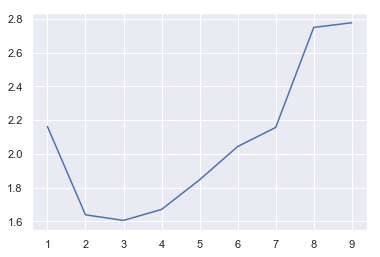

In [29]:
cl_len.ratio.groupby(number_phrases).mean().plot(kind='line')
plt.show()

In [30]:
ma_cl = cl_len.ratio.groupby(cl_len.number_phrases).mean()
ma_df_cl = pd.DataFrame(ma_cl)
ma_df_cl.reset_index(level=0, inplace=True)

[[Model]]
    Model(mla)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 9
    # variables        = 2
    chi-square         = 1.07402676
    reduced chi-square = 0.15343239
    Akaike info crit   = -15.1322870
    Bayesian info crit = -14.7378378
[[Variables]]
    a:  1.54471911 +/- 0.27471733 (17.78%) (init = 4.950447)
    b: -0.19929101 +/- 0.10505202 (52.71%) (init = 0.228)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.936



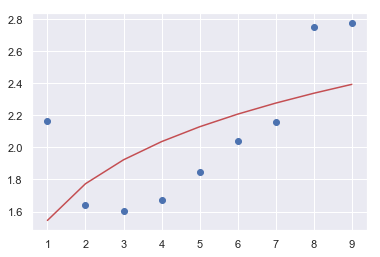

In [31]:
y = ma_df_cl.ratio
x = ma_df_cl.number_phrases

def mla(x, a, b):
    return (a*(1/x**b))

mlamodel_cl = Model(mla)
result_cl = mlamodel_cl.fit(y, x=x, a=4.950447, b=0.228)

print(result_cl.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result_cl.best_fit, 'r-')
plt.show()

In [32]:
a = result.params['a'].value
b = result.params['b'].value

In [33]:
SenLp = []

for n in range(1,32):
    SenLp.append(a*(1/n**-b))

SenLp_df = pd.DataFrame(SenLp)
ma_df_cl['senlp'] = SenLp_df

slope, intercept, r_value, p_value, std_err = stats.linregress(ma_df_cl.ratio, ma_df_cl.senlp)
print("r-squared:", r_value**2)

r-squared: 0.2945153588935955


Genesis r-squared: 0.07041688807246788
Genesis a: -0.0818907516481577


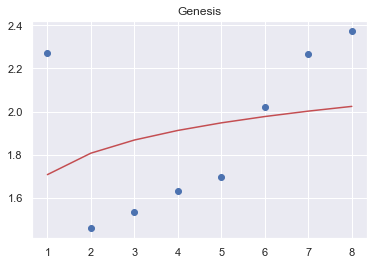

Exodus r-squared: 0.023468294345155453
Exodus a: 0.04705777616645054


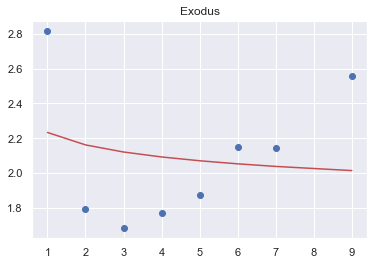

Leviticus r-squared: 0.14865957282918232
Leviticus a: 0.13449071009129418


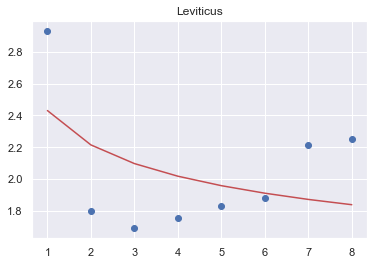

Numbers r-squared: 0.5734449733744105
Numbers a: 0.3284426196841292


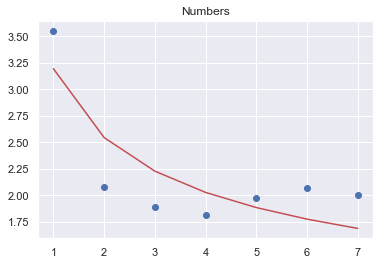

Deuteronomy r-squared: 0.3014349338552238
Deuteronomy a: -0.3378830240572791


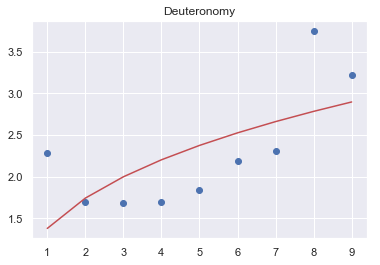

Joshua r-squared: 0.3901213615788194
Joshua a: 0.1400933022288803


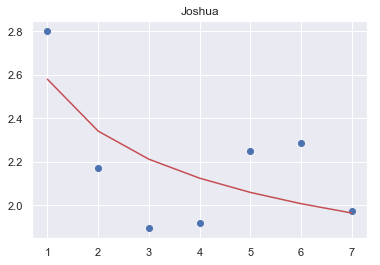

Judges r-squared: 0.4039337821390846
Judges a: -0.2689977628609853


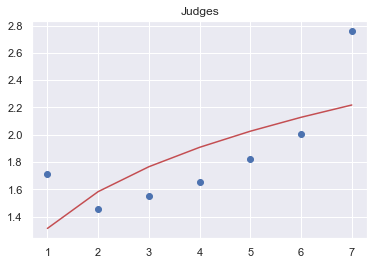

1_Samuel r-squared: 0.3052662078214144
1_Samuel a: -0.06590614552078837


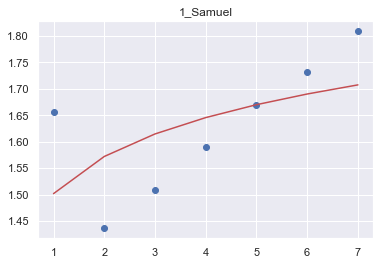

2_Samuel r-squared: 0.25253929900064354
2_Samuel a: 0.10130708863473971


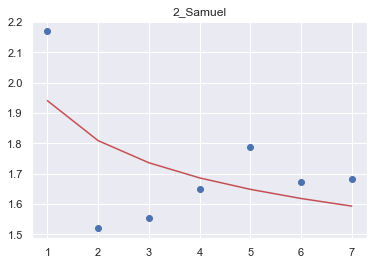

1_Kings r-squared: 0.13296058379969244
1_Kings a: -0.0898299206221382


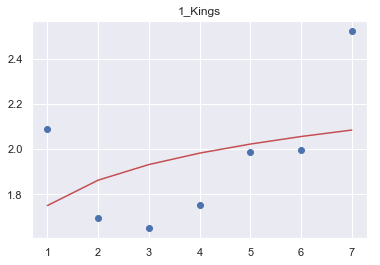

2_Kings r-squared: 0.452619384841924
2_Kings a: -0.2821052591820784


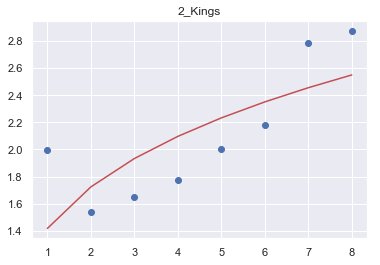

Isaiah r-squared: 0.27525792533396526
Isaiah a: -0.2712222977357036


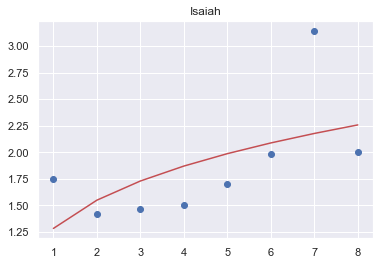

Jeremiah r-squared: 0.18086343059360227
Jeremiah a: -0.3558530846292372


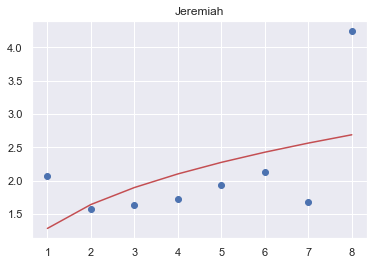

Ezekiel r-squared: 0.013011210143039867
Ezekiel a: -0.025854789503500123


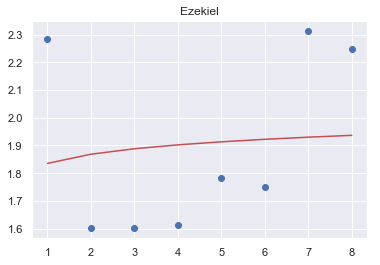

Hosea r-squared: 0.24134101232571892
Hosea a: -0.276927104517289


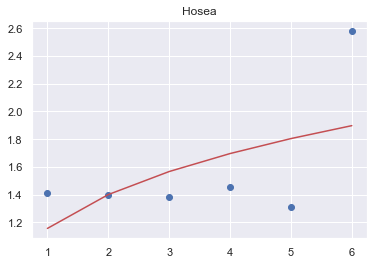

Joel r-squared: 0.7789444063216511
Joel a: 0.2993201513733742


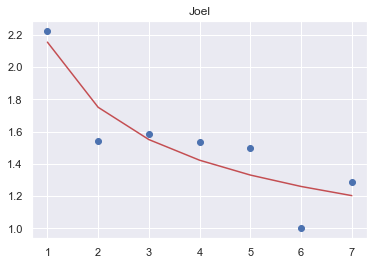

Amos r-squared: 0.197971012635734
Amos a: 0.07852923236096067


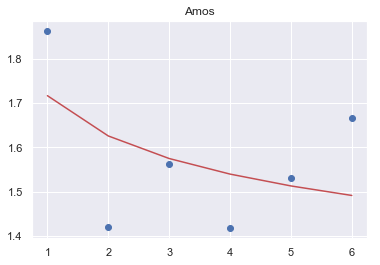

Obadiah r-squared: 0.018423003517552827
Obadiah a: -0.01095701983142109


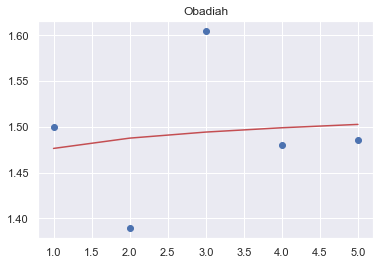

Jonah r-squared: 0.0776137089879098
Jonah a: -0.023741593088021578


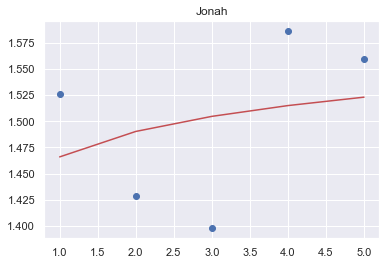

Micah r-squared: 0.05060632013664813
Micah a: 0.06675139154170295


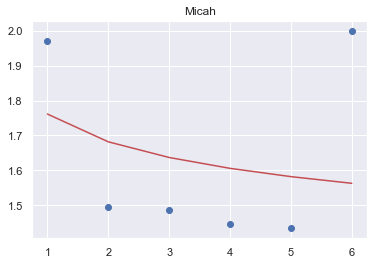

Nahum r-squared: 0.8453123013597729
Nahum a: 0.25598135878284617


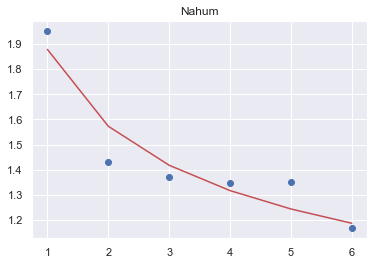

Habakkuk r-squared: 0.5990817734827389
Habakkuk a: 0.14183805159512666


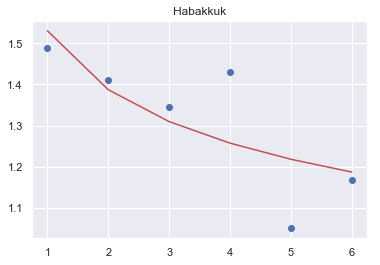

Zephaniah r-squared: 0.2820581847087658
Zephaniah a: 0.08818845620754155


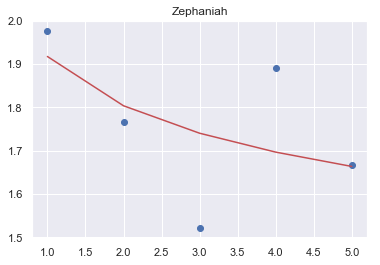

Haggai r-squared: 0.00224104579070984
Haggai a: -0.019420182618234465


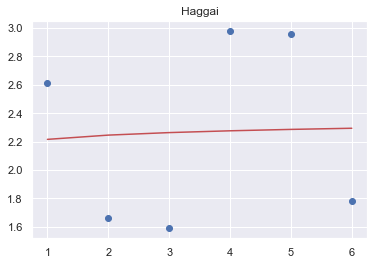

Zechariah r-squared: 0.044823849417758896
Zechariah a: -0.03895982416728653


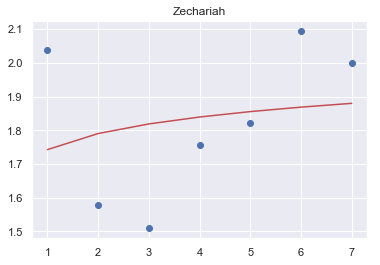

Malachi r-squared: 0.3706673265131546
Malachi a: 0.184576624485273


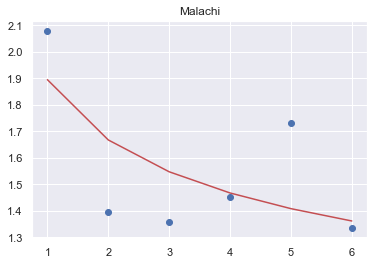

Psalms r-squared: 0.5429441748957814
Psalms a: 0.113285868497178


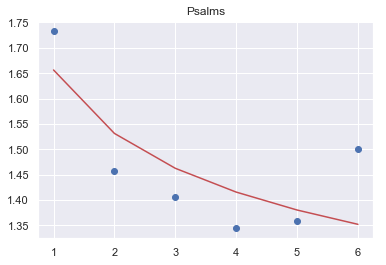

Job r-squared: 0.1386702276427614
Job a: 0.06112824447186151


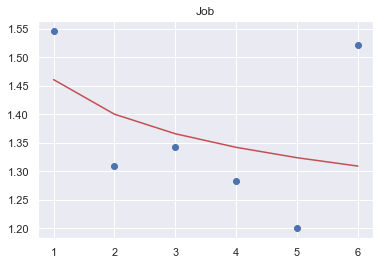

Proverbs r-squared: 0.003913565397201739
Proverbs a: -0.025018040006438615


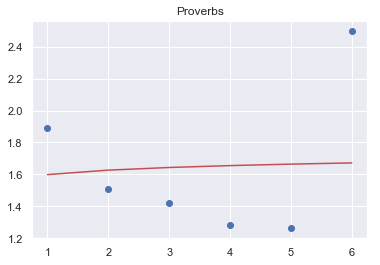

Ruth r-squared: 0.04878012704687145
Ruth a: 0.03304918583641984


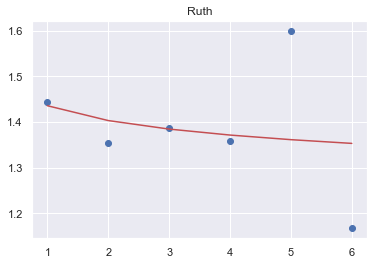

Song_of_songs r-squared: 0.14652862550474968
Song_of_songs a: 0.06523117744295108


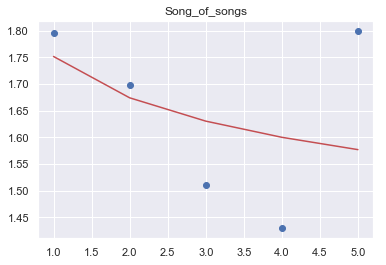

Ecclesiastes r-squared: 0.7141097915842093
Ecclesiastes a: 0.15944674294977196


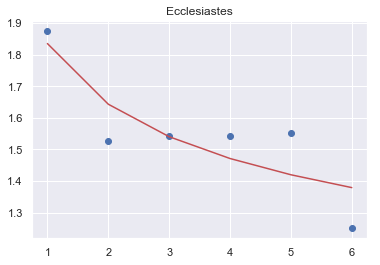

Lamentations r-squared: 0.07198103919697571
Lamentations a: 0.034816949850619235


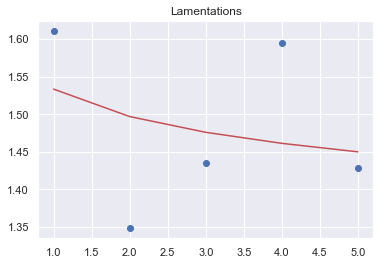

Esther r-squared: 0.12504450749264626
Esther a: -0.10761811715469549


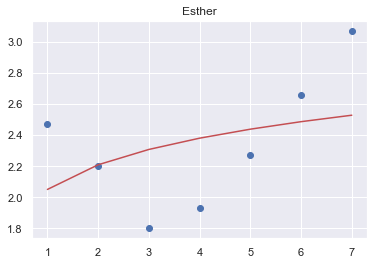

Daniel r-squared: 0.0052714200547506985
Daniel a: 0.013187632411624572


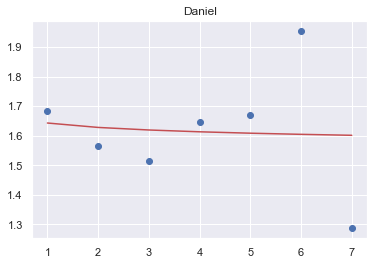

Ezra r-squared: 0.06068521102881868
Ezra a: 0.11384974675313243


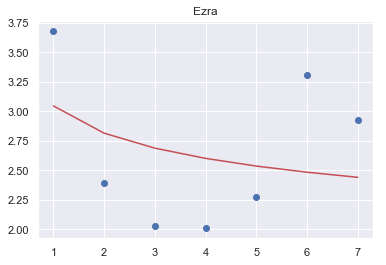

Nehemiah r-squared: 0.3618523352870004
Nehemiah a: 0.24394876295849025


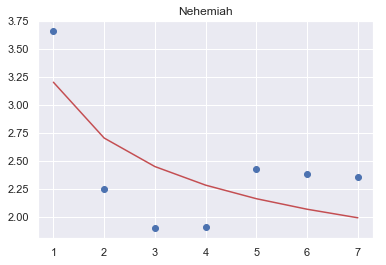

1_Chronicles r-squared: 0.6313946176251383
1_Chronicles a: 0.35732071059049364


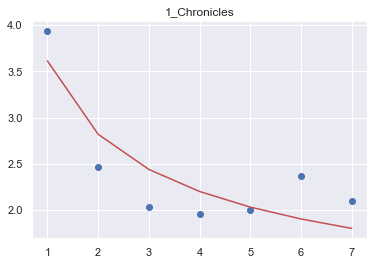

2_Chronicles r-squared: 6.13206396971259e-05
2_Chronicles a: 0.0011204227465674925


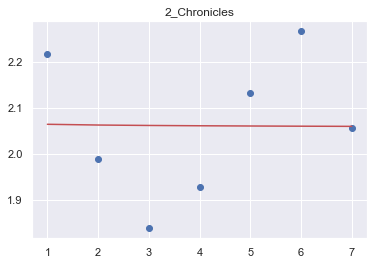

In [34]:
r2_cl = {}
variable_a_cl = {}
variable_b_cl = {}

for book in cl_len.book.unique():
    ma = cl_len.loc[cl_len['book'] == book].ratio.groupby(cl_len.number_phrases).mean()
    ma_df = pd.DataFrame(ma)
    ma_df.reset_index(level=0, inplace=True)
     
    y = ma_df.ratio
    x = ma_df.number_phrases

    def mla(x, a, b):
        return (a*(1/x**b))

    mlamodel = Model(mla)
    result = mlamodel.fit(y, x=x, a=4.950447, b=0.228)

    SenLp = []
    for n in range(1,32):
        SenLp.append(a*(1/n**-b))

    SenLp_df = pd.DataFrame(SenLp)
    ma_df['senlp'] = SenLp_df
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ma_df.ratio, ma_df.senlp)
    print(book, "r-squared:", r_value**2)
    r2_cl[book] = r_value**2
    v_a = result.params['a'].value
    v_b = result.params['b'].value
    variable_a[book] = v_a
    variable_b[book] = v_b
    print(book, 'a:',v_b)

    
    plt.plot(x, y, 'bo')
    plt.plot(x, result.best_fit, 'r-')
    plt.title(book)
    plt.show()

In [35]:
cl_phr = pd.DataFrame(list(r2_cl.items()), columns=['Book', 'R2'])
cl_phr['variable_a'] = cl_phr['Book'].map(variable_a)
cl_phr['variable_b'] = cl_phr['Book'].map(variable_b)

# Phrase - Word - Letter: Data Collection and Analysis

> now phrase level

In [36]:
phrase_list = []
phrase_dict = {}

number_phrases = []
number_words3 = []
word_letter_ratio = []

for phr in F.otype.s('phrase'):
    words = L.d(phr, 'word')
    word_counter = 0
    
    for word in words:  
        word_counter += 1
            
    all_letters = sum([len(F.g_cons.v(word)) for word in words])

    info_list3 = [str(phr)]
    
    where = T.sectionFromNode(phr)
    for elem in where:
        info_list3.append(str(elem))
    words3 = L.d(phr, 'word')
    lang3 = F.language.v(words3[0])
    info_list3.append(lang3)
    info_list3.append(str(word_counter))
    number_phrases.append(word_counter)
    info_list3.append(str(all_letters))
    number_words3.append(all_letters)
    info_list3.append(str(all_letters / word_counter))
    word_letter_ratio.append(all_letters / word_counter)

    
    phrase_list.append(phr)

    phrase_dict[phr] = info_list3

In [37]:
csvh = open('phrase_jarod.csv', "w")
header = ['id', 'book', 'chapter', 'verse', 'language', 'phrase_length', 'number_letters', 'word_length']
csvh.write('{}\n'.format(','.join(header)))
for phr in phrase_list:
    line = phrase_dict[phr]
    csvh.write('{}\n'.format(','.join(line)))
    
csvh.close()

In [38]:
phr_len = pd.read_csv('/Users/jAir/Desktop/ipynb/phrase_jarod.csv')

In [39]:
phr_len_20 = phr_len[phr_len['phrase_length'] < 21]

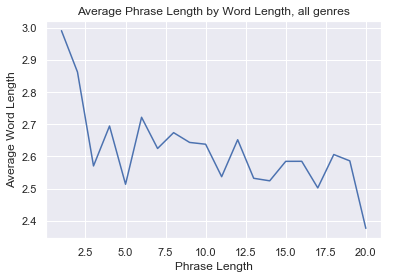

In [40]:
phr_len_20.word_length.groupby(phr_len.phrase_length).mean().plot(kind='line')
plt.xlabel('Phrase Length')
plt.ylabel('Average Word Length')
plt.title('Average Phrase Length by Word Length, all genres')
plt.show()

[[Model]]
    Model(mla)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 20
    # variables        = 2
    chi-square         = 0.12728282
    reduced chi-square = 0.00707127
    Akaike info crit   = -97.1415207
    Bayesian info crit = -95.1500562
[[Variables]]
    a:  2.89829604 +/- 0.05572178 (1.92%) (init = 2.9)
    b:  0.04786699 +/- 0.00868449 (18.14%) (init = 0.228)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.928



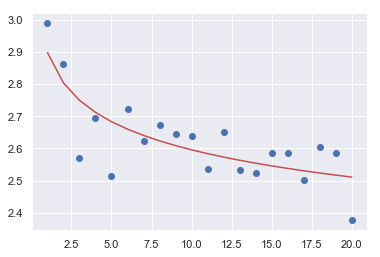

In [41]:
ma_phr = phr_len_20.word_length.groupby(phr_len_20.phrase_length).mean()
ma_phr_df = pd.DataFrame(ma_phr)
ma_phr_df.reset_index(level=0, inplace=True)
ma_phr_df.head()

y = ma_phr_df.word_length
x = ma_phr_df.phrase_length

def mla(x, a, b):
    return (a*(1/x**b))

mlamodel = Model(mla)
result = mlamodel.fit(y, x=x, a=2.9, b=0.228)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.best_fit, 'r-')
plt.show()

In [42]:
a_phr = result.params['a'].value
b_phr = result.params['b'].value

SenLp = []

for n in range(1,38):
    SenLp.append(a_phr*(1/n**-b_phr))

SenLp_df = pd.DataFrame(SenLp)
ma_phr_df['senlp'] = SenLp_df

slope, intercept, r_value, p_value, std_err = stats.linregress(ma_phr_df.word_length, ma_phr_df.senlp)
print("r-squared:", r_value**2)

r-squared: 0.603130712178255


Genesis r-squared: 0.31655303201107327
Genesis a: 0.055550551706562826


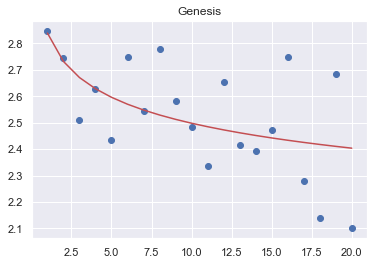

Exodus r-squared: 0.42662879726490094
Exodus a: 0.052443207058410685


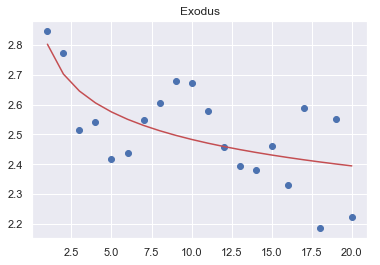

Leviticus r-squared: 0.4622986250477249
Leviticus a: 0.09230514432357173


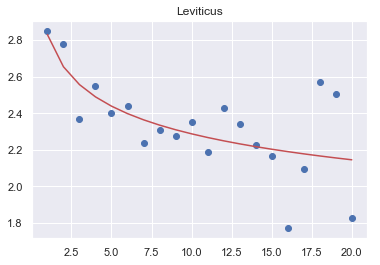

Numbers r-squared: 0.13679037325005391
Numbers a: 0.02711180001603193


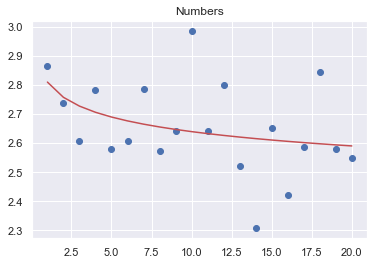

Deuteronomy r-squared: 0.2999377637295978
Deuteronomy a: 0.08149912567026273


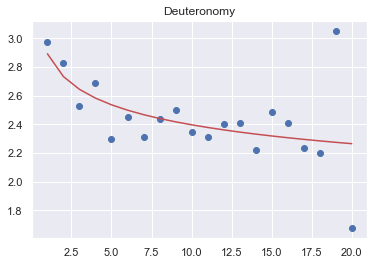

Joshua r-squared: 0.3091423743045695
Joshua a: 0.04311140987020126


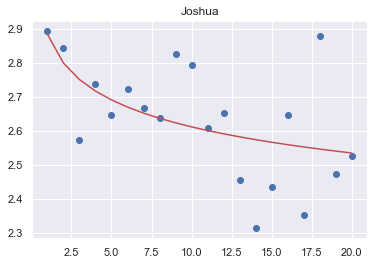

Judges r-squared: 0.4267398617291198
Judges a: 0.07404677028580073


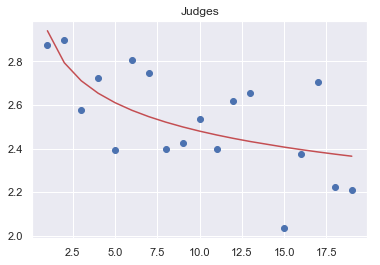

1_Samuel r-squared: 0.10961576743875974
1_Samuel a: 0.048430508693102996


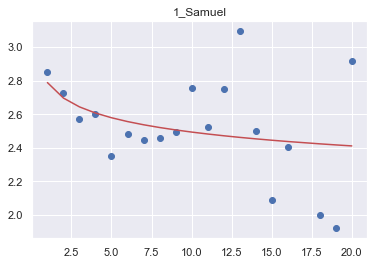

2_Samuel r-squared: 0.017961182028026147
2_Samuel a: 0.01158190997019262


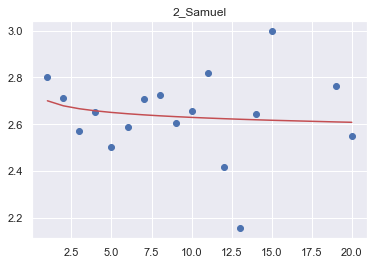

1_Kings r-squared: 0.3040334290994756
1_Kings a: 0.03918179182215739


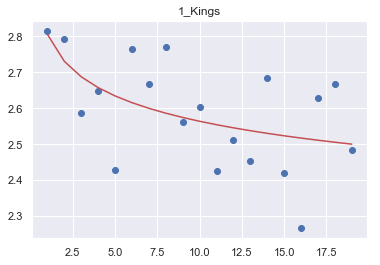

2_Kings r-squared: 0.4118121065763137
2_Kings a: 0.0863175280675534


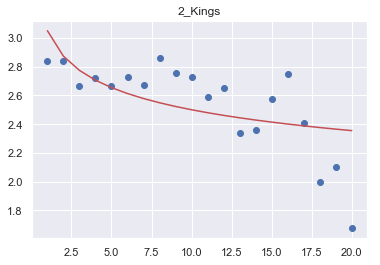

Isaiah r-squared: 0.23016813467802985
Isaiah a: 0.0609631756334433


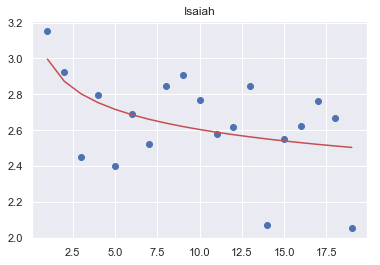

Jeremiah r-squared: 0.2570946656428402
Jeremiah a: 0.05370870439962038


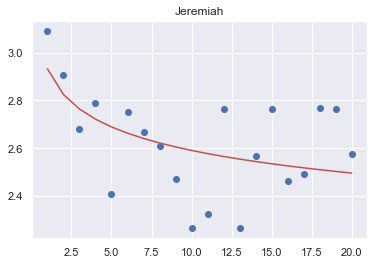

Ezekiel r-squared: 0.4627256672352338
Ezekiel a: 0.09576256019841249


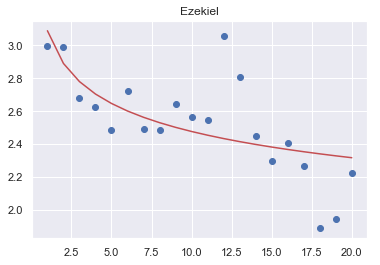

Hosea r-squared: 0.036006299969035094
Hosea a: 0.044289292917443504


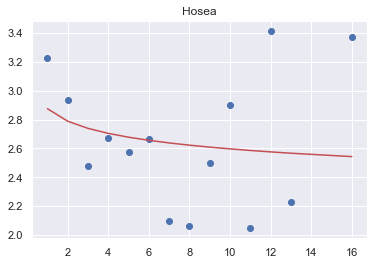

Joel r-squared: 0.7523857260517135
Joel a: 0.18525644098169056


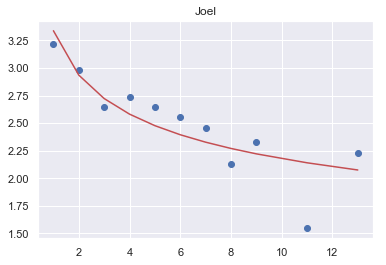

Amos r-squared: 0.05214767858969827
Amos a: -0.04789954693994695


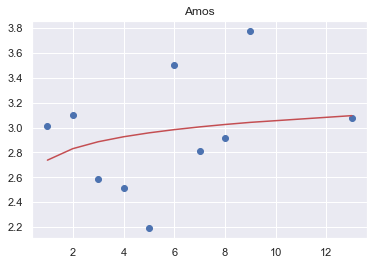

Obadiah r-squared: 0.20262458225965035
Obadiah a: 0.1294215645997033


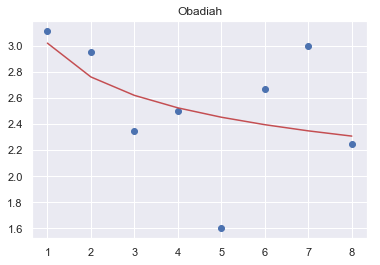

Jonah r-squared: 0.6541174045882486
Jonah a: 0.17249850071058234


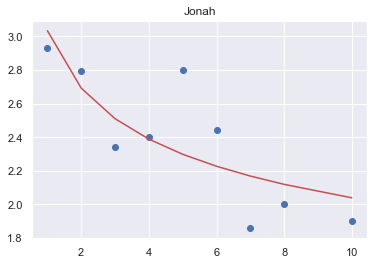

Micah r-squared: 0.37731294788245967
Micah a: 0.06554656409274462


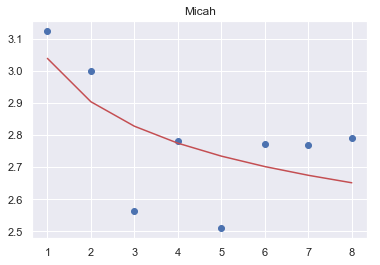

Nahum r-squared: 0.5213116564526902
Nahum a: 0.11930540079357495


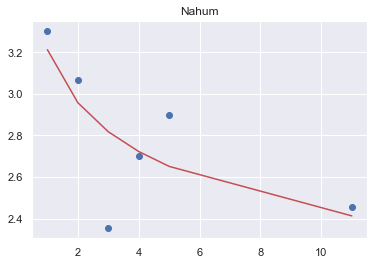

Habakkuk r-squared: 0.8325076016738847
Habakkuk a: 0.15670642380026603


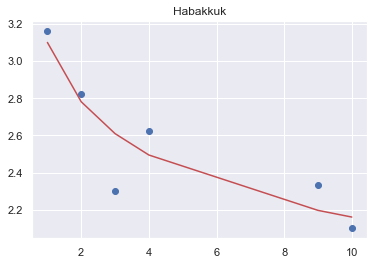

Zephaniah r-squared: 0.2059371098186967
Zephaniah a: 0.10338636767622984


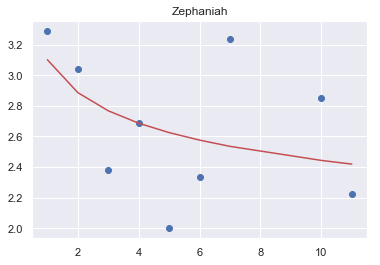

Haggai r-squared: 0.1381490733311313
Haggai a: 0.07387110336950088


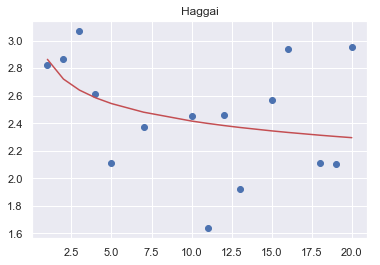

Zechariah r-squared: 0.40225611693561925
Zechariah a: 0.06682717783157996


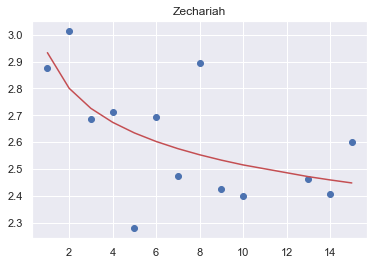

Malachi r-squared: 0.5042669970056579
Malachi a: 0.13919709241921643


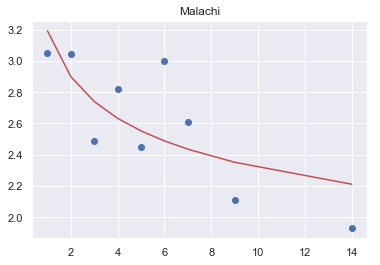

Psalms r-squared: 0.5993855877011468
Psalms a: 0.14173692551262587


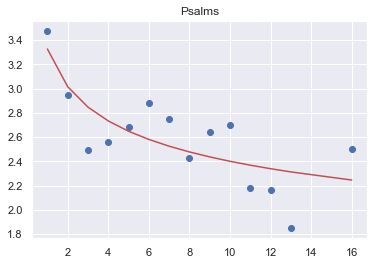

Job r-squared: 0.059471535220015484
Job a: -0.04155884212292633


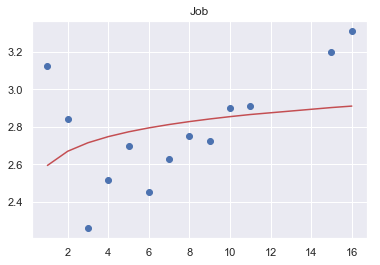

Proverbs r-squared: 0.3169431384140414
Proverbs a: 0.13527832827807576


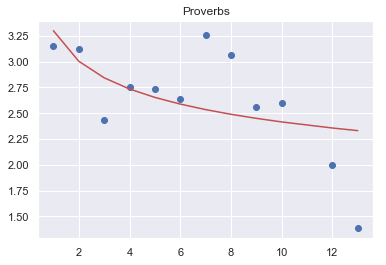

Ruth r-squared: 0.030589765468403918
Ruth a: -0.03091604559956332


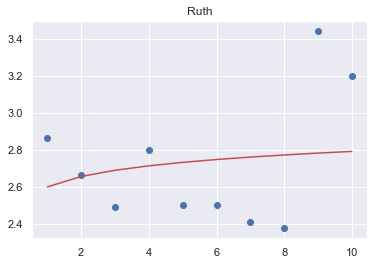

Song_of_songs r-squared: 0.4745346912867007
Song_of_songs a: 0.1596119338211882


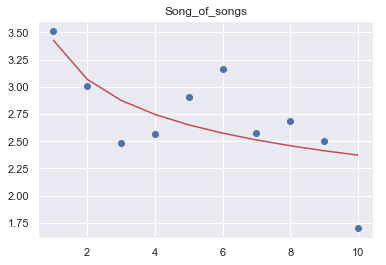

Ecclesiastes r-squared: 0.2324981604887252
Ecclesiastes a: 0.06468898010732081


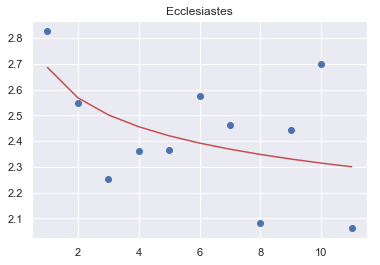

Lamentations r-squared: 0.7542810614249463
Lamentations a: 0.20611539168675022


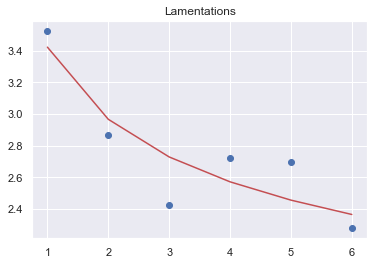

Esther r-squared: 0.08740292002217089
Esther a: -0.039823698051614904


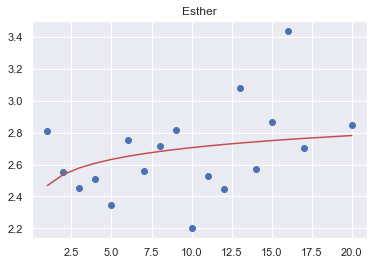

Daniel r-squared: 0.015639546020369485
Daniel a: -0.02526842496904186


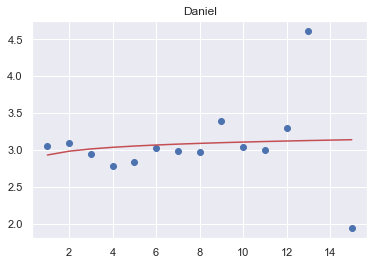

Ezra r-squared: 0.07672736706384937
Ezra a: 0.028658473987580018


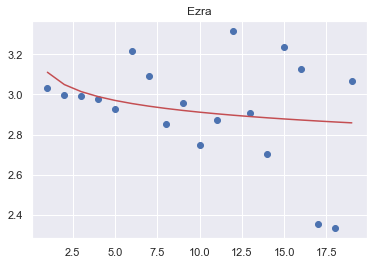

Nehemiah r-squared: 0.0018123458142141496
Nehemiah a: 0.00390145769111531


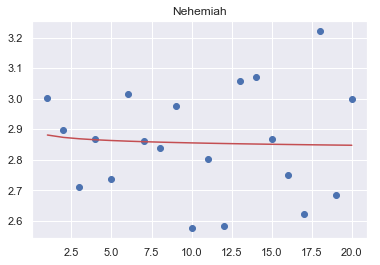

1_Chronicles r-squared: 0.04552273923471089
1_Chronicles a: 0.014503399597745005


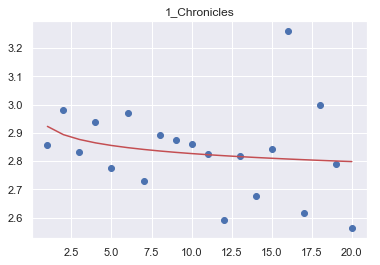

2_Chronicles r-squared: 0.10259398812013744
2_Chronicles a: 0.023962293683551884


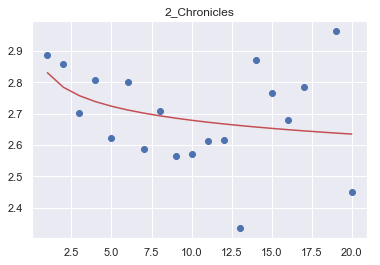

In [43]:
r2p = {}
variable_ap = {}
variable_bp = {}

for book in phr_len.book.unique():
    ma = phr_len_20.loc[phr_len_20['book'] == book].word_length.groupby(phr_len_20.phrase_length).mean()
    ma_df = pd.DataFrame(ma)
    ma_df.reset_index(level=0, inplace=True)
     
    y = ma_df.word_length
    x = ma_df.phrase_length

    def mla(x, a, b):
        return (a*(1/x**b))

    mlamodel = Model(mla)
    result = mlamodel.fit(y, x=x, a=4.950447, b=0.228)

    SenLp = []
    for n in range(1,32):
        SenLp.append(a*(1/n**-b))

    phrLp_df = pd.DataFrame(SenLp)
    ma_df['phrlp'] = phrLp_df
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ma_df.word_length, ma_df.phrlp)
    print(book, "r-squared:", r_value**2)
    r2p[book] = r_value**2
    v_a = result.params['a'].value
    v_b = result.params['b'].value
    variable_a[book] = v_a
    variable_b[book] = v_b
    print(book, 'a:',v_b)

    
    plt.plot(x, y, 'bo')
    plt.plot(x, result.best_fit, 'r-')
    plt.title(book)
    plt.show()

In [44]:
phr_word = pd.DataFrame(list(r2p.items()), columns=['Book', 'R2'])
phr_word['variable_a'] = phr_word['Book'].map(variable_a)
phr_word['variable_b'] = phr_word['Book'].map(variable_b)